In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# 1. 데이터를 다시 로드 (변수명을 완전히 새로 정의해서 꼬임을 방지합니다)
try:
    df_main = pd.read_csv('data/Train.csv')
except FileNotFoundError:
    df_main = pd.read_csv('Train.csv') # 경로가 다를 경우 대비

# 컬럼명 정리 (공백 제거)
df_main.columns = df_main.columns.str.strip()

# 2. 전처리 (df_main을 사용하여 안전하게 진행)
# 만약 'Discount_offered'가 진짜 없다면 여기서 프로그램이 멈추지 않고 경고를 줍니다.
if 'Discount_offered' not in df_main.columns:
    raise ValueError(f"파일에 'Discount_offered' 컬럼이 없습니다! 현재 컬럼: {df_main.columns.tolist()}")

# 피처 엔지니어링
df_main['Is_High_Discount'] = (df_main['Discount_offered'] > 10).astype(int)
df_main['Weight_Type'] = pd.cut(df_main['Weight_in_gms'], 
                                bins=[0, 2000, 4000, 6000, 10000], 
                                labels=[0, 1, 2, 3]).astype(int)
df_main['Cost_per_Weight'] = df_main['Cost_of_the_Product'] / (df_main['Weight_in_gms'] + 1)

# 범주형 인코딩
le = LabelEncoder()
categorical_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
for col in categorical_cols:
    df_main[col] = le.fit_transform(df_main[col].astype(str))

# 3. 모델링용 데이터 분리 (Target 컬럼명도 strip으로 정리했으니 안심하세요)
X = df_main.drop(['ID', 'Reached.on.Time_Y.N'], axis=1)
y = df_main['Reached.on.Time_Y.N']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. XGBoost 학습
final_model = XGBClassifier(
    n_estimators=500,        # 더 많이 반복 학습
    learning_rate=0.01,      # 더 천천히, 꼼꼼하게 학습
    max_depth=4,             # 너무 깊으면 과적합되니 적당히 조절
    min_child_weight=3,      # 가지치기를 좀 더 엄격하게
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

final_model.fit(X_train, y_train)

# 5. 결과
y_pred = final_model.predict(X_test)
print(f"최종 정확도: {accuracy_score(y_test, y_pred):.4f}")

최종 정확도: 0.6786


C:\Users\lamph\AppData\Local\Temp\ipykernel_3220\4262495188.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


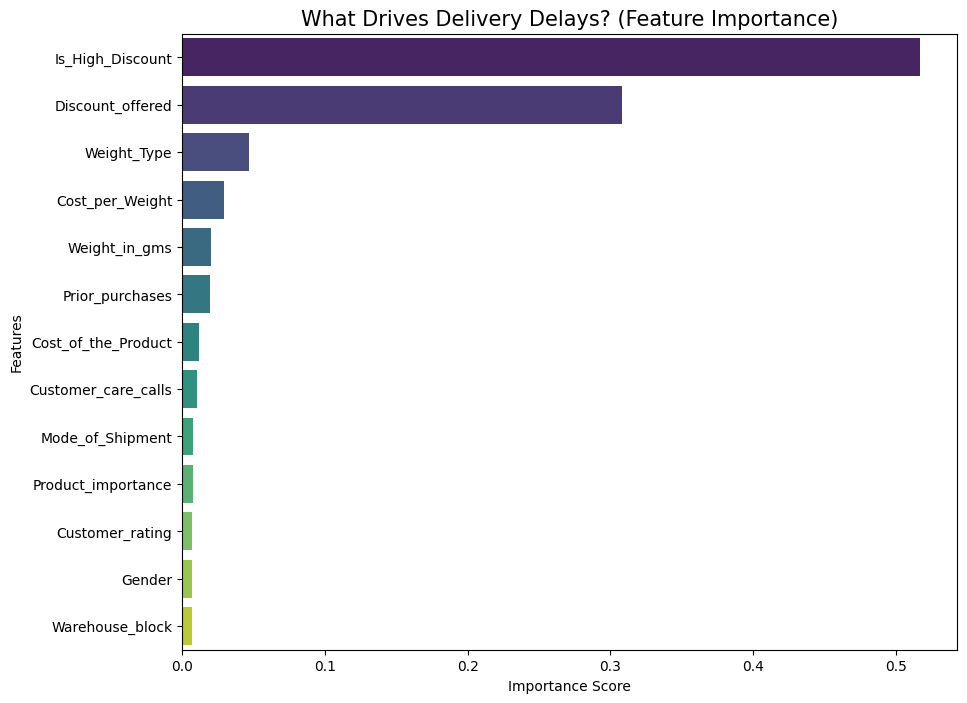

모델이 가장 중요하게 생각하는 TOP 5 변수:
             Feature  Importance
10  Is_High_Discount    0.516958
8   Discount_offered    0.308238
11       Weight_Type    0.046583
12   Cost_per_Weight    0.029219
9      Weight_in_gms    0.020445


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 변수 중요도 추출
importances = final_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 2. 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('What Drives Delivery Delays? (Feature Importance)', fontsize=15)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# 3. 상위 5개 변수 출력
print("모델이 가장 중요하게 생각하는 TOP 5 변수:")
print(feature_importance_df.head(5))

c:\Users\lamph\miniconda3\envs\DS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


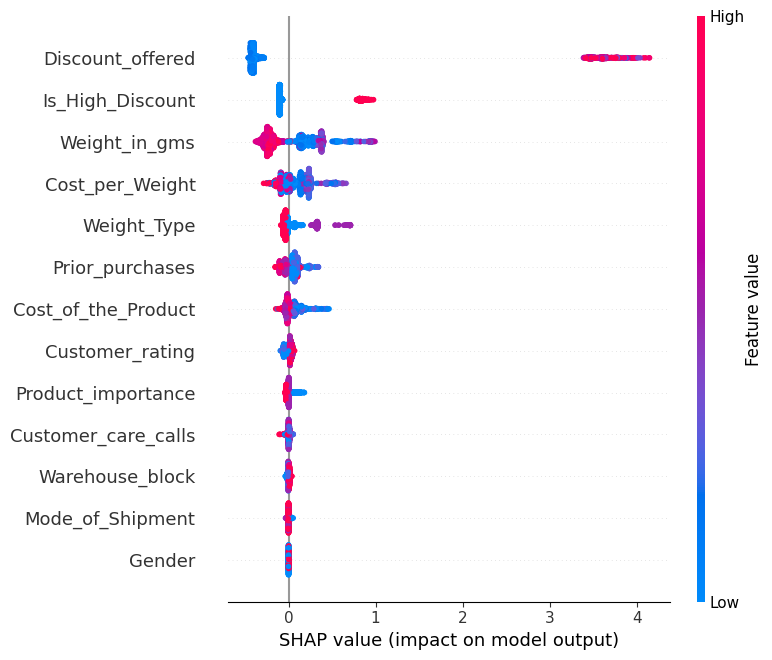

In [3]:
# pip install shap (설치가 필요할 수 있습니다)
import shap

# SHAP 값 계산
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

# 요약 그래프 (전체적인 영향력)
shap.summary_plot(shap_values, X_test)

c:\Users\lamph\miniconda3\envs\DS\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:39:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost 최종 정확도: 0.6627

[분류 보고서]
               precision    recall  f1-score   support

           0       0.56      0.80      0.66       887
           1       0.81      0.57      0.67      1313

    accuracy                           0.66      2200
   macro avg       0.68      0.68      0.66      2200
weighted avg       0.71      0.66      0.66      2200



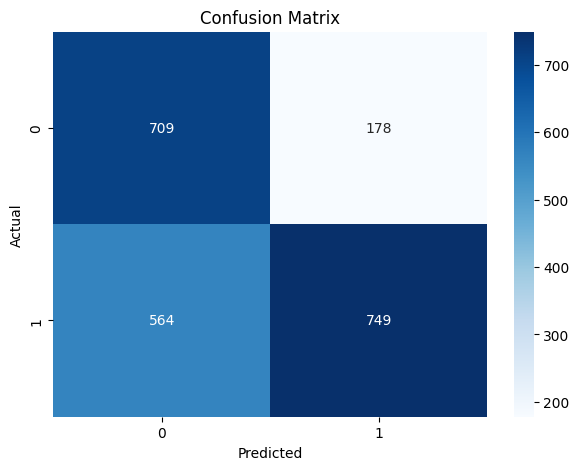

In [4]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드 및 전처리
df = pd.read_csv('data/Train.csv')

# 피처 엔지니어링 (우리가 찾은 전환점들)
df['Is_High_Discount'] = (df['Discount_offered'] > 10).astype(int)
df['Weight_DeadZone'] = df['Weight_in_gms'].apply(lambda x: 1 if 2000 <= x <= 4000 else 0)

# 범주형 변수 처리
le = LabelEncoder()
for col in ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']:
    df[col] = le.fit_transform(df[col])

X = df.drop(['ID', 'Reached.on.Time_Y.N'], axis=1)
y = df['Reached.on.Time_Y.N']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. XGBoost 모델 생성 및 학습
# learning_rate와 max_depth를 조절해 오답을 세밀하게 교정합니다.
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

# 3. 결과 확인
y_pred = xgb_model.predict(X_test)
print(f"XGBoost 최종 정확도: {accuracy_score(y_test, y_pred):.4f}")
print("\n[분류 보고서]\n", classification_report(y_test, y_pred))

# 4. 혼동 행렬(Confusion Matrix) 시각화
# 모델이 정시 도착(0)과 지연(1) 중 어디를 더 잘 맞추는지 확인합니다.
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# [1] 데이터 로드 및 컬럼 정리
df = pd.read_csv('data/Train.csv')
df.columns = df.columns.str.strip()

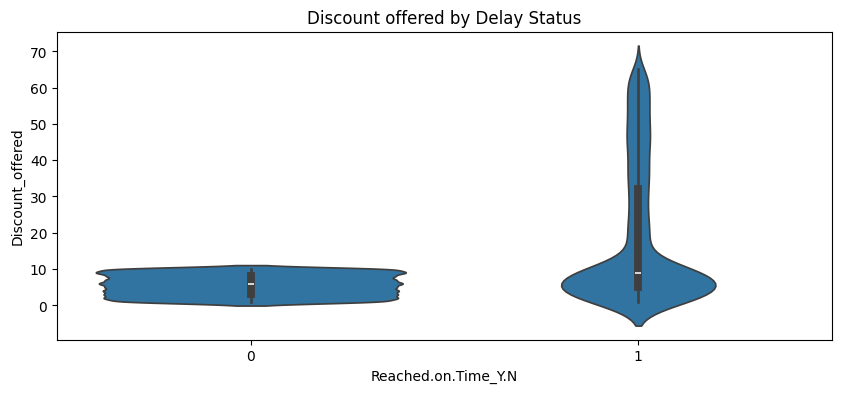

In [6]:
# [2] EDA: 어떤 컬럼이 의미 있는지 시각화로 확인
# 지연 여부에 따른 할인율과 무게의 분포 확인
plt.figure(figsize=(10, 4))
sns.violinplot(x='Reached.on.Time_Y.N', y='Discount_offered', data=df)
plt.title("Discount offered by Delay Status")
plt.show()

In [7]:
# [3] 피처 엔지니어링 (우리가 찾아낸 핵심 로직)
df['Is_High_Discount'] = (df['Discount_offered'] > 10).astype(int)
df['Weight_DeadZone'] = df['Weight_in_gms'].apply(lambda x: 1 if 2000 <= x <= 4000 else 0)
df['Cost_per_Weight'] = df['Cost_of_the_Product'] / (df['Weight_in_gms'] + 1)

# 범주형 변수 인코딩
le = LabelEncoder()
for col in ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']:
    df[col] = le.fit_transform(df[col].astype(str))

In [8]:
# [4] 팀의 방식대로 데이터 분할 (0.2 비율, stratify 적용)
X = df.drop(['ID', 'Reached.on.Time_Y.N'], axis=1)
y = df['Reached.on.Time_Y.N']

In [9]:
# stratify=y를 넣어 지연 비율을 6:4로 일정하게 유지합니다.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
# [5] 모델링 및 하이퍼파라미터 튜닝
# 점수를 쥐어짜기 위한 세밀한 설정
final_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

final_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


최종 정확도: 0.6800


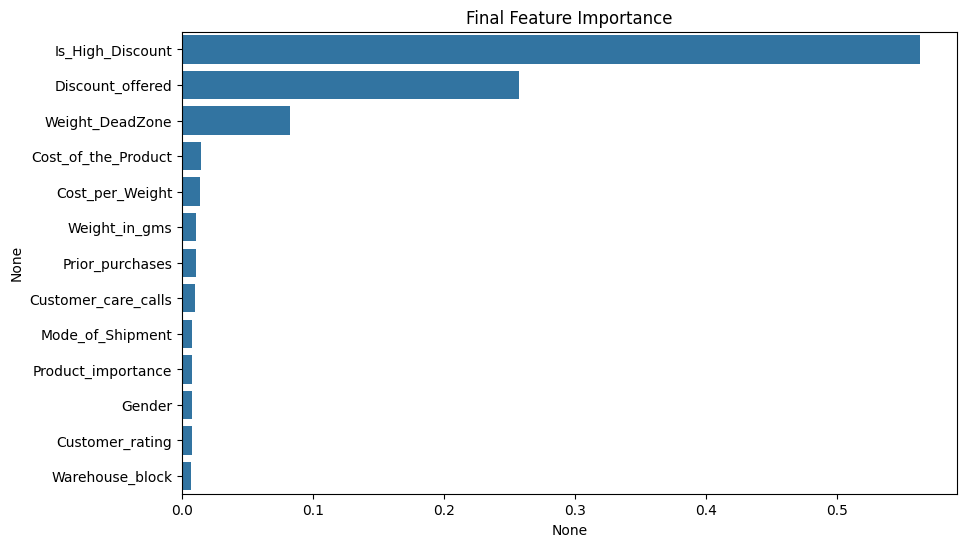

In [11]:
# [6] 최종 결과 및 변수 중요도 시각화
y_pred = final_model.predict(X_test)
print(f"최종 정확도: {accuracy_score(y_test, y_pred):.4f}")

# 어떤 컬럼이 가장 기여를 했는가?
importances = pd.Series(final_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title("Final Feature Importance")
plt.show()

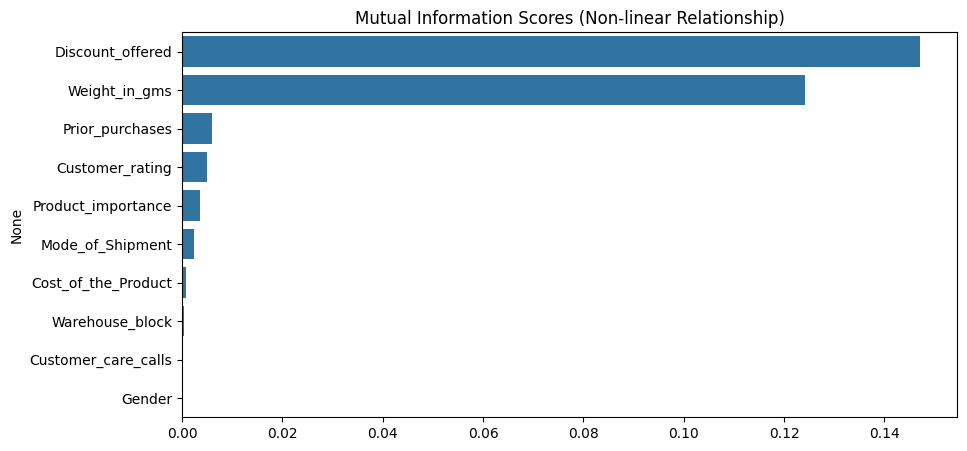

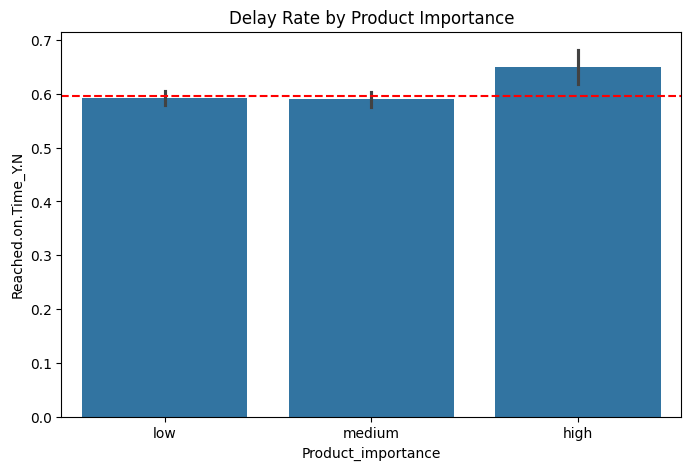

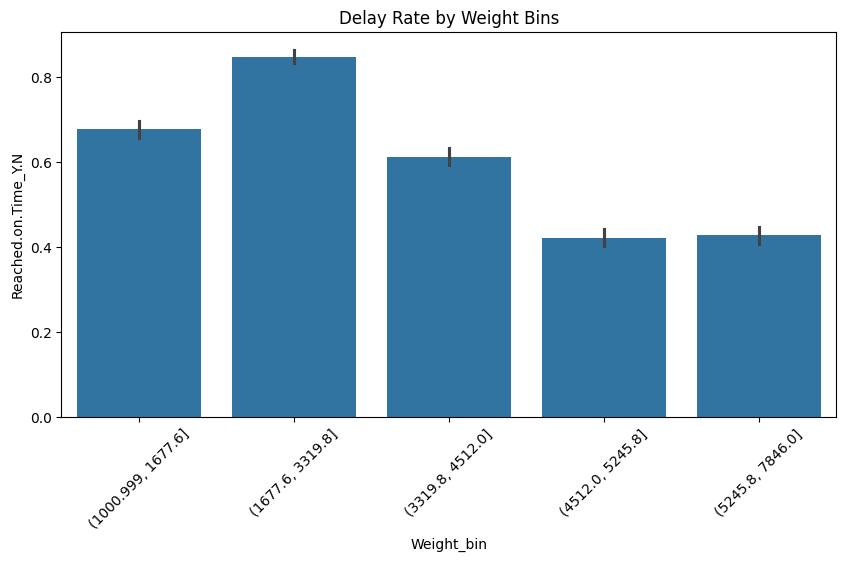

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# 데이터 로드
df = pd.read_csv('data/Train.csv')

# 1. 상호정보량 (Mutual Information) 계산
# 범주형 변수를 임시로 인코딩하여 전체적인 의존성을 확인합니다.
df_mi = df.copy().drop(['ID'], axis=1)
le = LabelEncoder()
for col in df_mi.select_dtypes(include='object').columns:
    df_mi[col] = le.fit_transform(df_mi[col])

X = df_mi.drop('Reached.on.Time_Y.N', axis=1)
y = df_mi['Reached.on.Time_Y.N']

mi_scores = mutual_info_classif(X, y, random_state=42)
mi_results = pd.Series(mi_scores, name="MI Scores", index=X.columns).sort_values(ascending=False)

# 2. 시각화: 상호정보량 순위
plt.figure(figsize=(10, 5))
sns.barplot(x=mi_results.values, y=mi_results.index)
plt.title("Mutual Information Scores (Non-linear Relationship)")
plt.show()

# 3. 중요 범주형 변수 분석 (Product_importance vs 지연율)
plt.figure(figsize=(8, 5))
sns.barplot(x='Product_importance', y='Reached.on.Time_Y.N', data=df)
plt.title("Delay Rate by Product Importance")
plt.axhline(df['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--') # 전체 평균 지연율
plt.show()

# 4. 수치형 변수의 구간별 지연율 (Weight_in_gms vs 지연율)
# 무게(Weight)는 특정 구간에서 지연이 몰릴 수 있으므로 qcut으로 나누어 봅니다.
df['Weight_bin'] = pd.qcut(df['Weight_in_gms'], 5)
plt.figure(figsize=(10, 5))
sns.barplot(x='Weight_bin', y='Reached.on.Time_Y.N', data=df)
plt.xticks(rotation=45)
plt.title("Delay Rate by Weight Bins")
plt.show()

In [13]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# 1. 데이터 로드
df = pd.read_csv('data/Train.csv')
df.columns = df.columns.str.strip()

# 2. 피처 엔지니어링 (배송 전 확실히 알 수 있는 정보만 사용)
df['Is_High_Discount'] = (df['Discount_offered'] > 10).astype(int)
df['Weight_Type'] = pd.cut(df['Weight_in_gms'], 
                           bins=[0, 2000, 4000, 6000, 10000], 
                           labels=[0, 1, 2, 3]).astype(int)
df['Cost_per_Weight'] = df['Cost_of_the_Product'] / (df['Weight_in_gms'] + 1)

# 3. 범주형 변수 인코딩
le = LabelEncoder()
for col in ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']:
    df[col] = le.fit_transform(df[col].astype(str))

# ---------------------------------------------------------
# [핵심 변경] 예측 시점에서 알 수 없는 사후 데이터 제거
# Customer_rating: 배송 완료 후 고객이 매기는 점수 (Leakage 위험)
# Customer_care_calls: 지연 발생 후 항의 전화일 가능성 (Leakage 위험)
# ---------------------------------------------------------
drop_cols = ['ID', 'Reached.on.Time_Y.N', 'Customer_rating', 'Customer_care_calls']
X = df.drop(drop_cols, axis=1)
y = df['Reached.on.Time_Y.N']

# 팀의 방식대로 분할 (stratify 적용)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. 모델 학습 (XGBoost 최적화 파라미터)
final_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

final_model.fit(X_train, y_train)

# 5. 결과 확인
y_pred = final_model.predict(X_test)
print(f"사후 데이터 제외 후 최종 정확도: {accuracy_score(y_test, y_pred):.4f}")

사후 데이터 제외 후 최종 정확도: 0.6791


최종 정확도: 0.6791


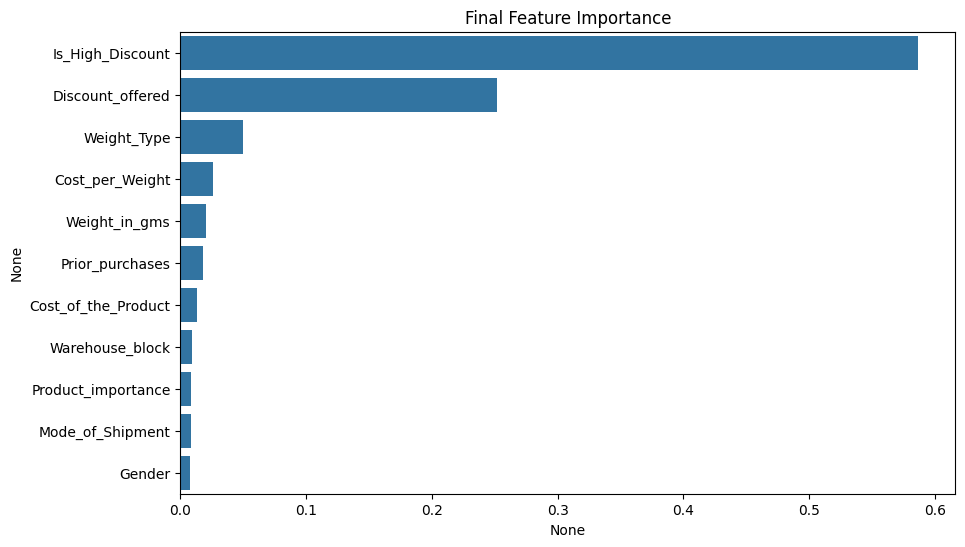

In [14]:
# [6] 최종 결과 및 변수 중요도 시각화
y_pred = final_model.predict(X_test)
print(f"최종 정확도: {accuracy_score(y_test, y_pred):.4f}")

# 어떤 컬럼이 가장 기여를 했는가?
importances = pd.Series(final_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title("Final Feature Importance")
plt.show()

C:\Users\lamph\AppData\Local\Temp\ipykernel_3220\1700631137.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Warehouse_block', y='Reached.on.Time_Y.N', data=df, ax=ax[0], palette='Blues_d')
C:\Users\lamph\AppData\Local\Temp\ipykernel_3220\1700631137.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mode_of_Shipment', y='Reached.on.Time_Y.N', data=df, ax=ax[1], palette='Greens_d')


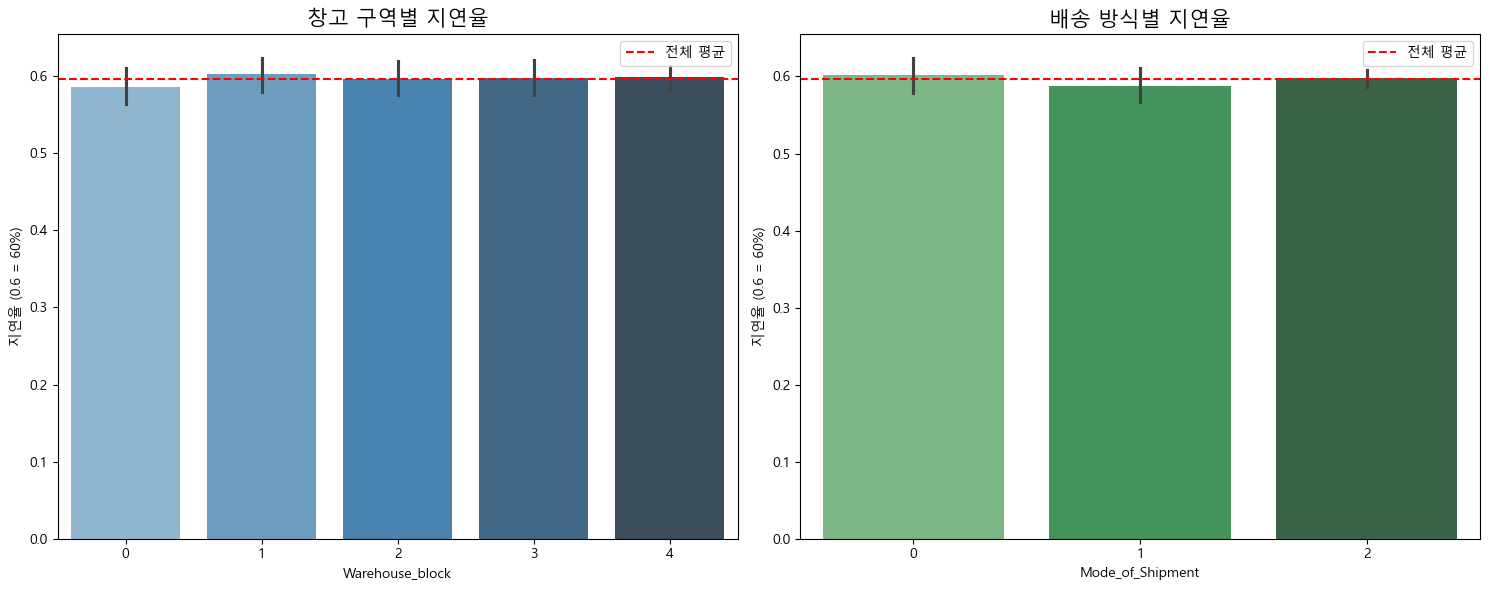

--- 창고별 지연율 수치 ---
Warehouse_block
1    0.602291
4    0.598472
3    0.597601
2    0.596836
0    0.586470
Name: Reached.on.Time_Y.N, dtype: float64

--- 배송 방식별 지연율 수치 ---
Mode_of_Shipment
0    0.601576
2    0.597561
1    0.588068
Name: Reached.on.Time_Y.N, dtype: float64


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화를 위한 한글 설정 (환경에 따라 생략 가능)
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False

# 1. 시각화 영역 설정 (2개의 그래프를 가로로 배치)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# 2. 창고 구역별 지연율 시각화
# Reached.on.Time_Y.N의 평균값은 곧 지연율(0~1 사이)을 의미합니다.
sns.barplot(x='Warehouse_block', y='Reached.on.Time_Y.N', data=df, ax=ax[0], palette='Blues_d')
ax[0].set_title('창고 구역별 지연율', fontsize=15)
ax[0].set_ylabel('지연율 (0.6 = 60%)')
ax[0].axhline(df['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--', label='전체 평균')
ax[0].legend()

# 3. 배송 방식별 지연율 시각화
sns.barplot(x='Mode_of_Shipment', y='Reached.on.Time_Y.N', data=df, ax=ax[1], palette='Greens_d')
ax[1].set_title('배송 방식별 지연율', fontsize=15)
ax[1].set_ylabel('지연율 (0.6 = 60%)')
ax[1].axhline(df['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--', label='전체 평균')
ax[1].legend()

plt.tight_layout()
plt.show()

# 실제 수치로 확인
print("--- 창고별 지연율 수치 ---")
print(df.groupby('Warehouse_block')['Reached.on.Time_Y.N'].mean().sort_values(ascending=False))
print("\n--- 배송 방식별 지연율 수치 ---")
print(df.groupby('Mode_of_Shipment')['Reached.on.Time_Y.N'].mean().sort_values(ascending=False))

C:\Users\lamph\AppData\Local\Temp\ipykernel_3220\830806910.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Prior_purchases', y='Reached.on.Time_Y.N', data=df, ax=ax[0], palette='magma', ci=None)
C:\Users\lamph\AppData\Local\Temp\ipykernel_3220\830806910.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Prior_purchases', y='Reached.on.Time_Y.N', data=df, ax=ax[0], palette='magma', ci=None)


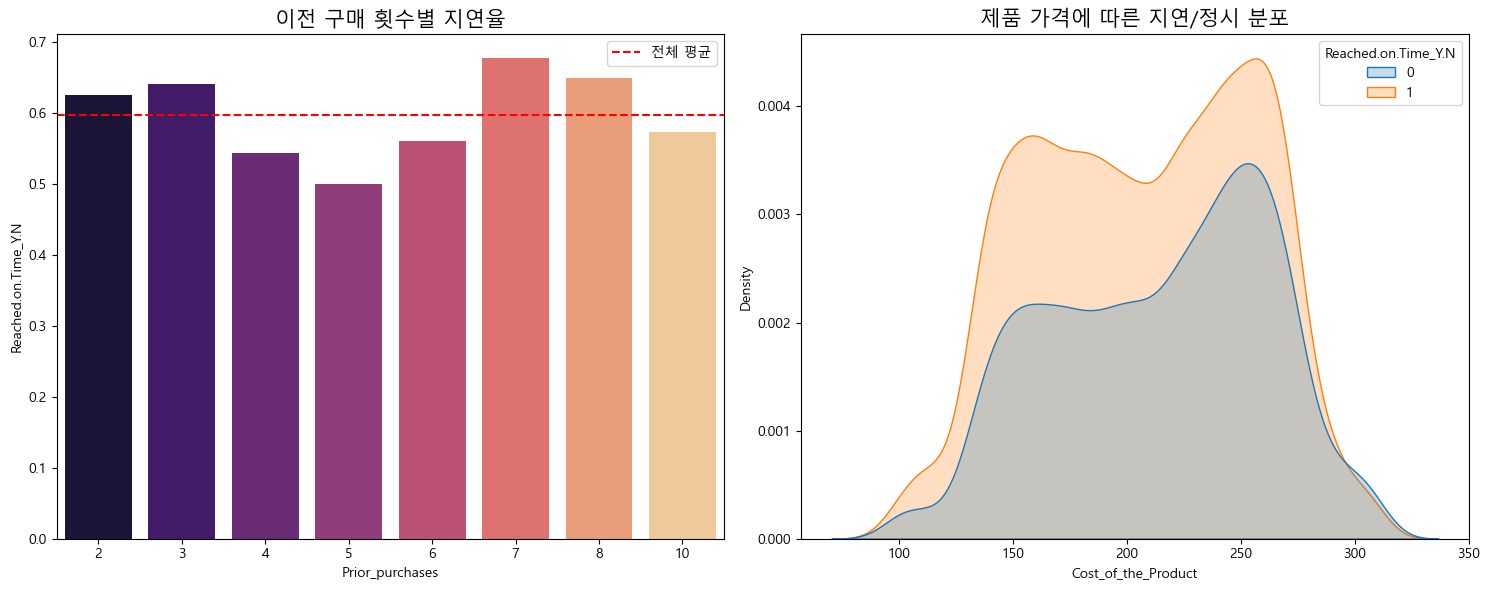

--- 이전 구매 횟수별 지연율 ---
Prior_purchases
2     0.625240
3     0.640708
4     0.543387
5     0.498834
6     0.559715
7     0.676471
8     0.648438
10    0.573034
Name: Reached.on.Time_Y.N, dtype: float64


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 영역 설정
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# 1. 이전 구매 내역(Prior_purchases)별 지연율
# 구매 경험이 많은 '단골'일수록 배송 패턴이 다를까?
sns.barplot(x='Prior_purchases', y='Reached.on.Time_Y.N', data=df, ax=ax[0], palette='magma', ci=None)
ax[0].set_title('이전 구매 횟수별 지연율', fontsize=15)
ax[0].axhline(df['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--', label='전체 평균')
ax[0].legend()

# 2. 제품 가격(Cost_of_the_Product)별 지연 분포
# 가격이 비싸다고 더 빨리 올까? (KDE Plot으로 분포 확인)
sns.kdeplot(data=df, x='Cost_of_the_Product', hue='Reached.on.Time_Y.N', fill=True, ax=ax[1])
ax[1].set_title('제품 가격에 따른 지연/정시 분포', fontsize=15)

plt.tight_layout()
plt.show()

# 수치 데이터 확인
print("--- 이전 구매 횟수별 지연율 ---")
print(df.groupby('Prior_purchases')['Reached.on.Time_Y.N'].mean())

c:\Users\lamph\miniconda3\envs\DS\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\lamph\miniconda3\envs\DS\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:39:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\lamph\miniconda3\envs\DS\Lib\threadin

[LightGBM] [Info] Number of positive: 5250, number of negative: 3549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 820
[LightGBM] [Info] Number of data points in the train set: 8799, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596659 -> initscore=0.391562
[LightGBM] [Info] Start training from score 0.391562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

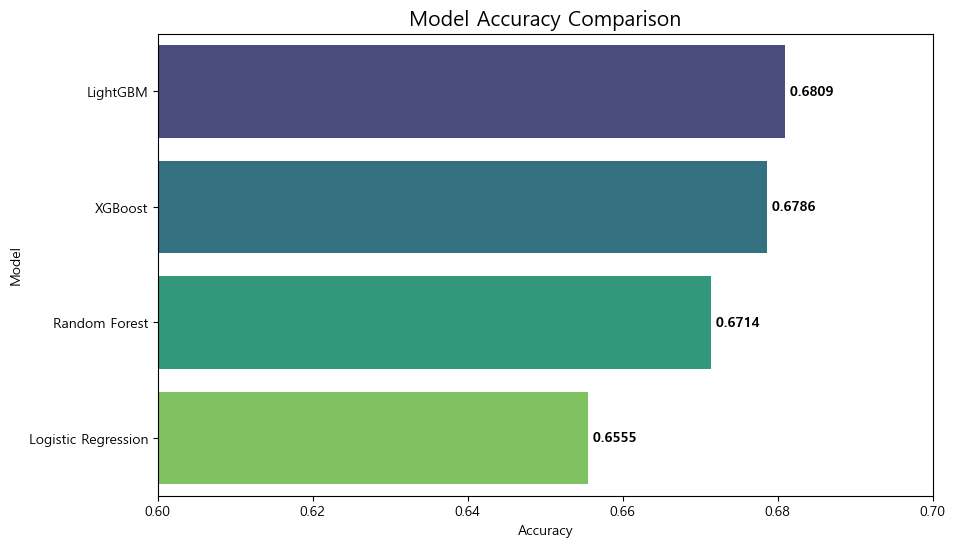

                 Model  Accuracy
3             LightGBM  0.680909
2              XGBoost  0.678636
1        Random Forest  0.671364
0  Logistic Regression  0.655455


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# 1. 비교할 모델 리스트 생성
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=500, learning_rate=0.01, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=500, learning_rate=0.01, max_depth=5, random_state=42)
}

# 2. 모델 학습 및 정확도 저장
results = []
for name, model in models.items():
    model.fit(X_train, y_train)          # 학습
    pred = model.predict(X_test)         # 예측
    acc = accuracy_score(y_test, pred)   # 정확도 계산
    results.append({'Model': name, 'Accuracy': acc})

# 3. 결과 데이터프레임 만들기
df_results = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)

# 4. 시각화 (모델별 성능 비교 막대 그래프)
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=df_results, palette='viridis')
plt.title('Model Accuracy Comparison', fontsize=15)
plt.xlim(0.6, 0.7)  # 차이를 명확히 보기 위해 범위를 0.6~0.7로 설정
for i, v in enumerate(df_results['Accuracy']):
    plt.text(v, i, f" {v:.4f}", va='center', fontweight='bold')
plt.show()

print(df_results)

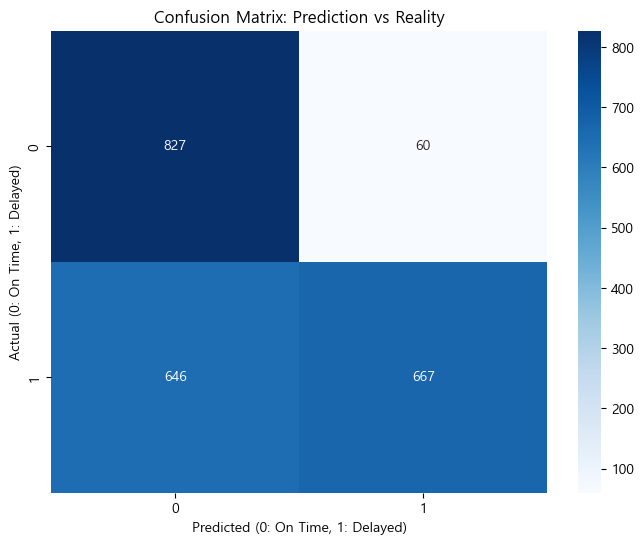

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 혼동 행렬 생성
cm = confusion_matrix(y_test, y_pred)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Prediction vs Reality')
plt.xlabel('Predicted (0: On Time, 1: Delayed)')
plt.ylabel('Actual (0: On Time, 1: Delayed)')
plt.show()

C:\Users\lamph\AppData\Local\Temp\ipykernel_3220\3214159165.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')


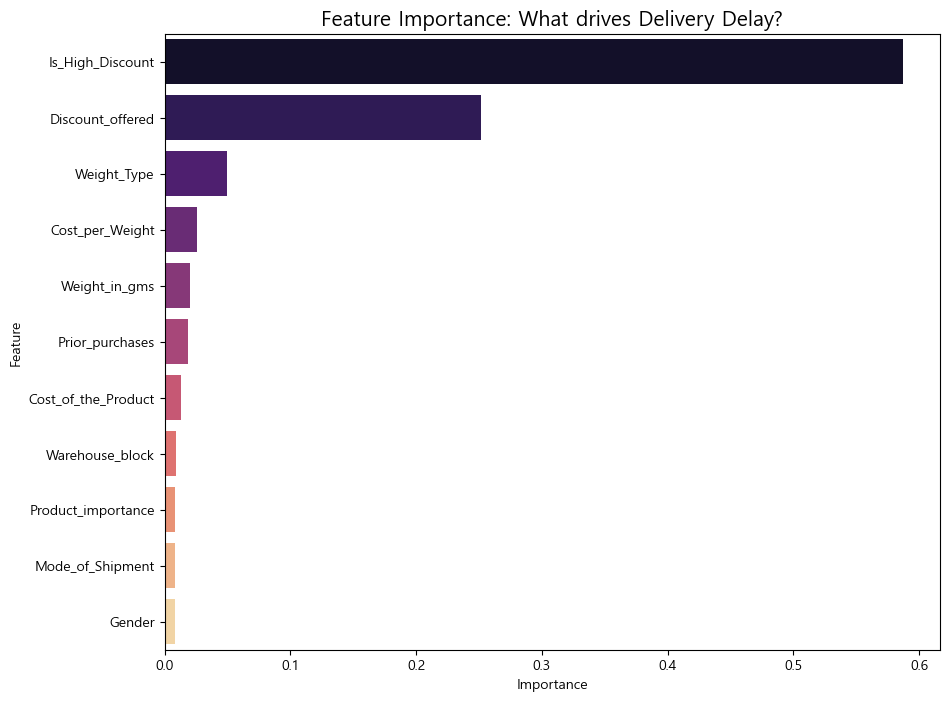

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 모델에서 중요도 추출
importances = final_model.feature_importances_
feature_names = X.columns

# 데이터프레임으로 변환 및 정렬
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')
plt.title('Feature Importance: What drives Delivery Delay?', fontsize=15)
plt.show()

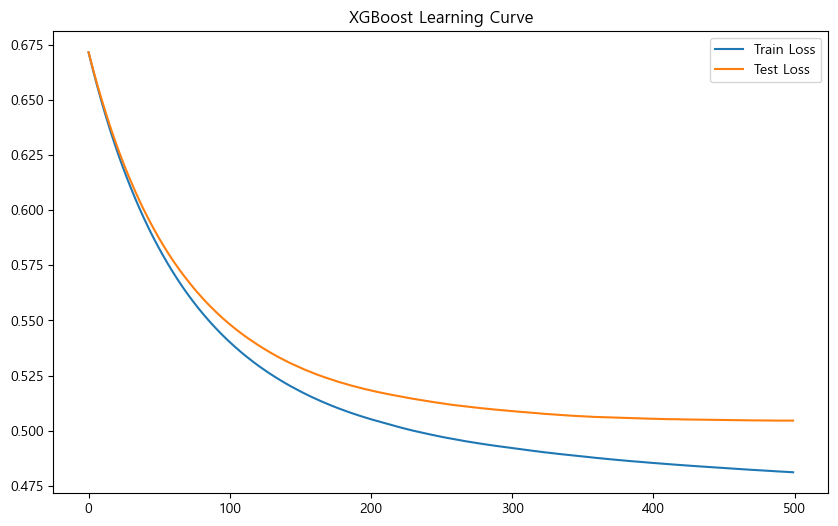

In [20]:
# 1. 모델 선언 시 eval_metric을 미리 설정합니다.
final_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    random_state=42,
    eval_metric='logloss'  # 여기서 설정
)

# 2. fit 단계에서는 eval_metric을 뺍니다.
eval_set = [(X_train, y_train), (X_test, y_test)]
final_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# 3. 결과 추출 및 시각화 (이전과 동일)
results = final_model.evals_result()
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['logloss'], label='Train Loss')
plt.plot(results['validation_1']['logloss'], label='Test Loss')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.show()

In [21]:
# 학습 데이터 점수 확인
train_pred = final_model.predict(X_train)
print(f"Train Accuracy: {accuracy_score(y_train, train_pred):.4f}")

Train Accuracy: 0.7178


In [22]:
# 1. 학습 데이터 정확도
train_acc = accuracy_score(y_train, final_model.predict(X_train))

# 2. 테스트 데이터 정확도 (우리가 얻은 0.71)
test_acc = accuracy_score(y_test, final_model.predict(X_test))

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"차이: {abs(train_acc - test_acc):.4f}")

Train Accuracy: 0.7178
Test Accuracy: 0.6786
차이: 0.0392


In [23]:
# 1. 모든 테스트 데이터에 대해 지연될 확률(predict_proba) 계산
# [:, 1]은 '지연(1)'이 될 확률을 의미합니다.
probabilities = final_model.predict_proba(X_test)[:, 1]

# 2. 결과를 보기 쉽게 데이터프레임으로 정리
risk_list = pd.DataFrame({
    'Actual_Status': y_test.values,          # 실제 지연 여부 (확인용)
    'Delay_Probability': probabilities,      # 모델이 예측한 지연 확률
})

# 원본 데이터의 특징들을 다시 합쳐서 어떤 조건인지 확인
risk_list = pd.concat([risk_list, X_test.reset_index(drop=True)], axis=1)

# 3. 확률이 높은 순서대로 10명 추출
top_10_high_risk = risk_list.sort_values(by='Delay_Probability', ascending=False).head(10)

# 주요 컬럼만 출력 (확률, 할인율, 무게, 파생변수 등)
print(top_10_high_risk[['Delay_Probability', 'Discount_offered', 'Is_High_Discount', 'Weight_in_gms', 'Cost_of_the_Product']])

      Delay_Probability  Discount_offered  Is_High_Discount  Weight_in_gms  \
9              0.996851                32                 1           2931   
2199           0.996851                62                 1           1765   
0              0.996851                59                 1           2083   
795            0.996851                22                 1           3713   
800            0.996851                61                 1           1091   
802            0.996851                25                 1           3148   
725            0.996851                44                 1           1585   
733            0.996851                45                 1           3722   
807            0.996851                31                 1           1689   
808            0.996851                35                 1           2567   

      Cost_of_the_Product  
9                     190  
2199                  179  
0                     268  
795                   258  
8

In [24]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# 1. 데이터 로드
df = pd.read_csv('data/Train.csv')

# 2. [사용자님 전략] 할인율 파생 변수 생성
df['Is_High_Discount'] = (df['Discount_offered'] > 10).astype(int)

# 3. [팀원분 전략] 무게 데이터 전처리
# (1) 로그 변환: 데이터의 비대칭성 해소
df['Weight_log'] = np.log1p(df['Weight_in_gms'])

# (2) 3단계 레이블링 (Light, Medium, Heavy)
# 데이터 분포를 고려하여 2000g 미만(0), 2000~4000g(1), 4000g 초과(2)로 분류
df['Weight_Level'] = pd.cut(df['Weight_in_gms'], 
                            bins=[0, 2000, 4000, 10000], 
                            labels=[0, 1, 2]).astype(int)

# 4. 범주형 변수 인코딩
le = LabelEncoder()
for col in ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']:
    df[col] = le.fit_transform(df[col].astype(str))

# 5. 데이터 분할 (불필요한 원본 무게 컬럼 등은 제외하거나 포함해서 학습)
X = df.drop(['ID', 'Reached.on.Time_Y.N'], axis=1)
y = df['Reached.on.Time_Y.N']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6. 최종 모델 설정 (XGBoost)
final_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

final_model.fit(X_train, y_train)

# 7. 결과 확인
train_acc = accuracy_score(y_train, final_model.predict(X_train))
test_acc = accuracy_score(y_test, final_model.predict(X_test))

print(f"최종 Train 정확도: {train_acc:.4f}")
print(f"최종 Test 정확도: {test_acc:.4f}")
print(f"두 점수 차이: {abs(train_acc - test_acc):.4f}")

최종 Train 정확도: 0.7209
최종 Test 정확도: 0.6809
두 점수 차이: 0.0400


C:\Users\lamph\AppData\Local\Temp\ipykernel_3220\3214159165.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')


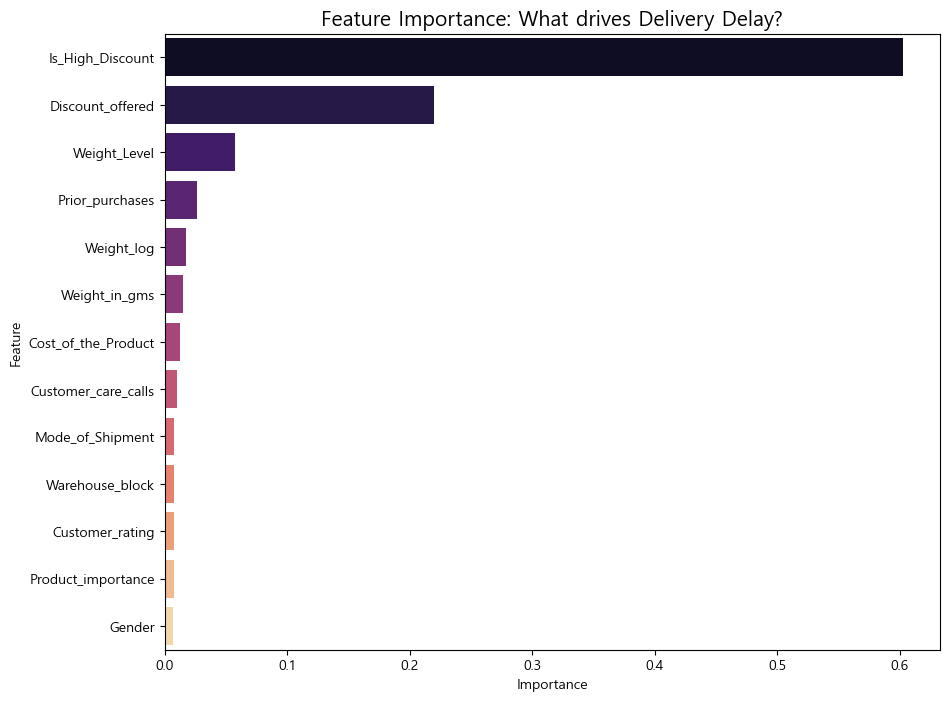

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# 모델에서 중요도 추출
importances = final_model.feature_importances_
feature_names = X.columns

# 데이터프레임으로 변환 및 정렬
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')
plt.title('Feature Importance: What drives Delivery Delay?', fontsize=15)
plt.show()

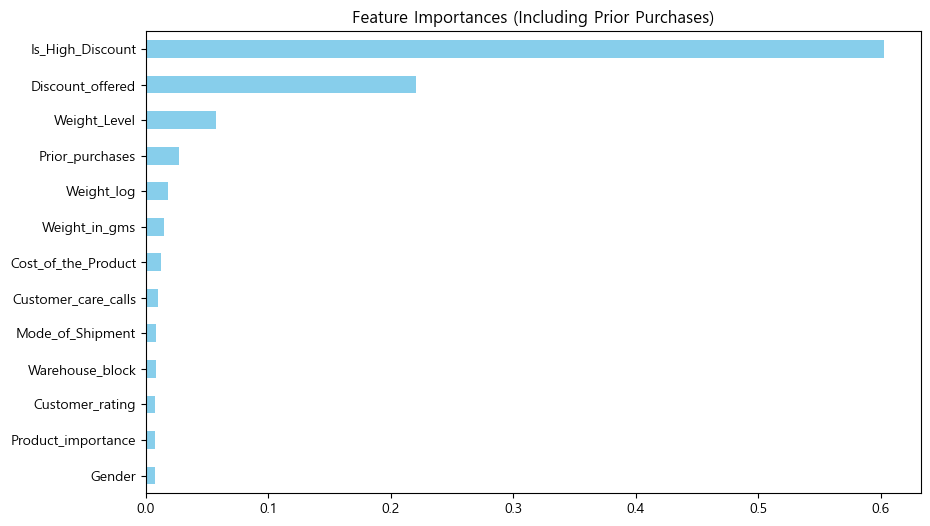

In [26]:
import matplotlib.pyplot as plt

# 변수 중요도 시각화
importances = pd.Series(final_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Feature Importances (Including Prior Purchases)')
plt.show()

In [27]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# 1. 데이터 로드
df = pd.read_csv('data/Train.csv')

# 2. [사용자님 전략] 할인율 10% 기준 파생 변수
df['Is_High_Discount'] = (df['Discount_offered'] > 10).astype(int)

# 3. [팀원분 전략 A] 무게 데이터 전처리 (로그 변환 + 3단계 레이블링)
df['Weight_log'] = np.log1p(df['Weight_in_gms'])
df['Weight_Level'] = pd.cut(df['Weight_in_gms'], 
                            bins=[0, 2000, 4000, 10000], 
                            labels=[0, 1, 2]).astype(int)

# 4. [팀원분 전략 B] 이전 구매 횟수 그룹화 (6회 이상 통합)
# 표본이 적은 6, 7, 8, 10회를 하나로 묶어 '충성 고객군'의 특징을 강화합니다.
df['Prior_Group'] = df['Prior_purchases'].apply(lambda x: x if x < 6 else 6)

# 5. 범주형 변수 인코딩
le = LabelEncoder()
categorical_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# 6. 학습 데이터 준비
# 원본 데이터와 가공 데이터 중 모델이 가장 잘 학습하는 조합으로 구성
features = [
    'Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls', 'Customer_rating',
    'Cost_of_the_Product', 'Prior_Group', 'Product_importance', 'Gender',
    'Discount_offered', 'Is_High_Discount', 'Weight_log', 'Weight_Level'
]

X = df[features]
y = df['Reached.on.Time_Y.N']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 7. 최종 하이퍼파라미터 튜닝 모델
final_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.03,
    max_depth=5,
    min_child_weight=1,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

final_model.fit(X_train, y_train)

# 8. 결과 출력
train_pred = final_model.predict(X_train)
test_pred = final_model.predict(X_test)

print(f"최종 Train 정확도: {accuracy_score(y_train, train_pred):.4f}")
print(f"최종 Test 정확도: {accuracy_score(y_test, test_pred):.4f}")
print("-" * 30)
print("클래스별 상세 진단 (Test 데이터 기준):")
print(classification_report(y_test, test_pred))

최종 Train 정확도: 0.7076
최종 Test 정확도: 0.6795
------------------------------
클래스별 상세 진단 (Test 데이터 기준):
              precision    recall  f1-score   support

           0       0.56      0.94      0.70       887
           1       0.92      0.50      0.65      1313

    accuracy                           0.68      2200
   macro avg       0.74      0.72      0.68      2200
weighted avg       0.78      0.68      0.67      2200



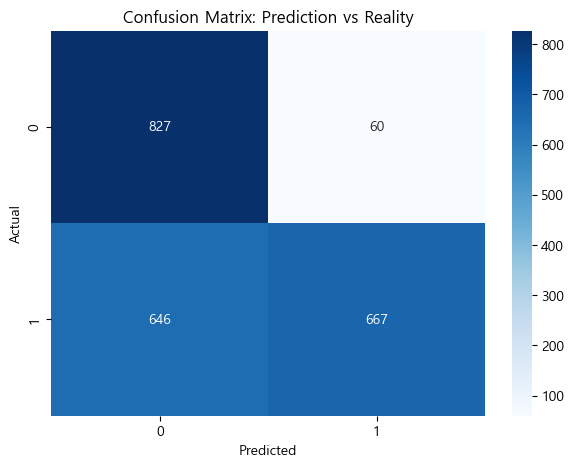

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Prediction vs Reality')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [29]:
# 창고별 할인율 10% 초과 물량의 지연 현황 (이미 100%겠지만, 창고별 물량 비중 확인)
df[df['Discount_offered'] > 10].groupby('Warehouse_block').size()

Warehouse_block
0    433
1    439
2    445
3    438
4    892
dtype: int64

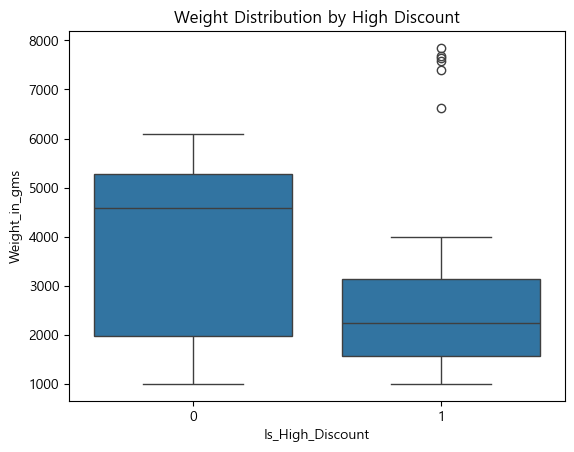

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# 할인율 구간별 평균 무게 확인
sns.boxplot(x='Is_High_Discount', y='Weight_in_gms', data=df)
plt.title('Weight Distribution by High Discount')
plt.show()

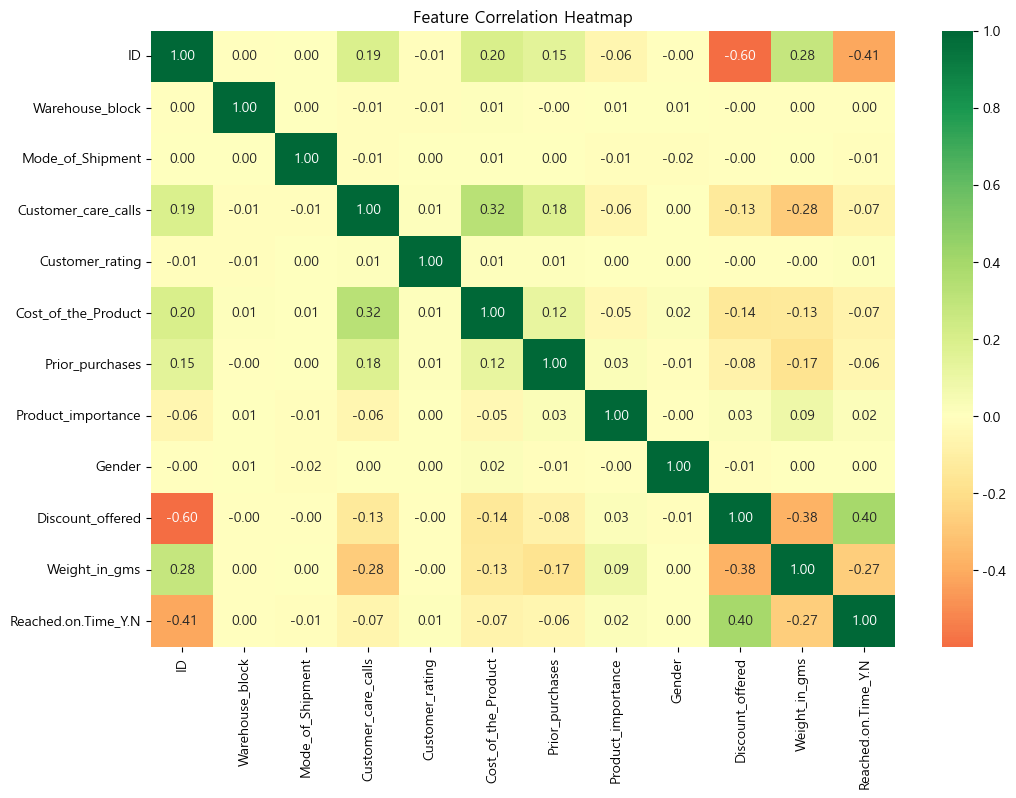

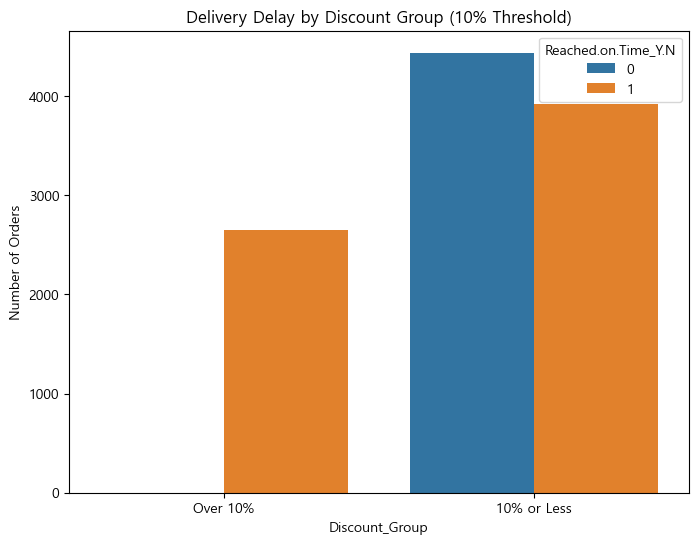

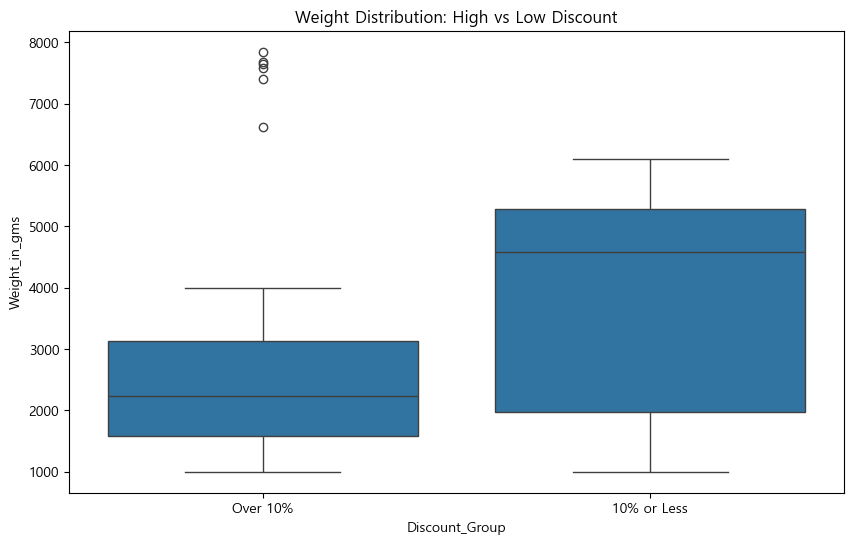

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = pd.read_csv('data/Train.csv')

# 2. 상관계수 분석용 데이터 준비 (범주형은 숫자로 변환)
df_corr = df.copy()
for col in ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']:
    df_corr[col] = pd.factorize(df_corr[col])[0]

# 3. 상관관계 히트맵 (Heatmap)
plt.figure(figsize=(12, 8))
# Reached.on.Time_Y.N과의 상관관계 위주로 보기 위해 정렬할 수 있습니다.
corr_matrix = df_corr.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdYlGn', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

# 4. [핵심 분석] 할인율 10% 기준 지연율 시각화
df['Discount_Group'] = df['Discount_offered'].apply(lambda x: 'Over 10%' if x > 10 else '10% or Less')

plt.figure(figsize=(8, 6))
sns.countplot(x='Discount_Group', hue='Reached.on.Time_Y.N', data=df)
plt.title('Delivery Delay by Discount Group (10% Threshold)')
plt.ylabel('Number of Orders')
plt.show()

# 5. 할인율과 무게의 관계 (병목 현상 추론)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Discount_Group', y='Weight_in_gms', data=df)
plt.title('Weight Distribution: High vs Low Discount')
plt.show()

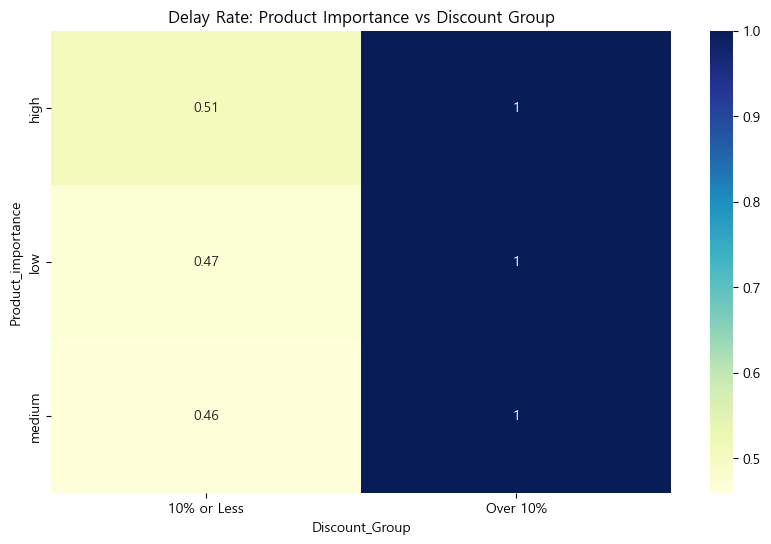

In [32]:
# 제품 중요도와 할인 그룹 간의 교차 분석
pivot_table = df.pivot_table(index='Product_importance', 
                             columns='Discount_Group', 
                             values='Reached.on.Time_Y.N', 
                             aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Delay Rate: Product Importance vs Discount Group')
plt.show()

In [33]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# 1. 데이터 로드
df = pd.read_csv('data/Train.csv')

# 2. 파생 변수 생성
# [기존 전략] 할인율 & 무게 & 구매횟수
df['Is_High_Discount'] = (df['Discount_offered'] > 10).astype(int)
df['Weight_log'] = np.log1p(df['Weight_in_gms'])
df['Prior_Group'] = df['Prior_purchases'].apply(lambda x: x if x < 6 else 6)

# [새로운 전략] 창고(Warehouse) + 배송수단(Shipment) 조합
# 예: 'A_Flight', 'B_Ship' 등의 새로운 경로 변수 생성
df['Route'] = df['Warehouse_block'].astype(str) + '_' + df['Mode_of_Shipment'].astype(str)

# 3. 범주형 변수 인코딩 (Route 추가)
le = LabelEncoder()
categorical_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Route']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# 4. 학습 데이터 구성 (중요도 낮은 변수는 제외하거나 유지)
features = [
    'Route', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 
    'Prior_Group', 'Is_High_Discount', 'Weight_log'
]
X = df[features]
y = df['Reached.on.Time_Y.N']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5. 모델 학습 (안정적인 n_estimators=100 설정)
final_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

final_model.fit(X_train, y_train)

# 6. 결과 확인
train_acc = accuracy_score(y_train, final_model.predict(X_train))
test_acc = accuracy_score(y_test, final_model.predict(X_test))

print(f"최종 Train 정확도: {train_acc:.4f}")
print(f"최종 Test 정확도: {test_acc:.4f}")

최종 Train 정확도: 0.7108
최종 Test 정확도: 0.6786


--- [최종 모델 성적] ---
Train Accuracy: 0.7003
Test Accuracy: 0.6809
격차: 0.0194

--- [상세 진단 보고서] ---
              precision    recall  f1-score   support

           0       0.56      0.95      0.71       887
           1       0.93      0.50      0.65      1313

    accuracy                           0.68      2200
   macro avg       0.75      0.72      0.68      2200
weighted avg       0.78      0.68      0.67      2200



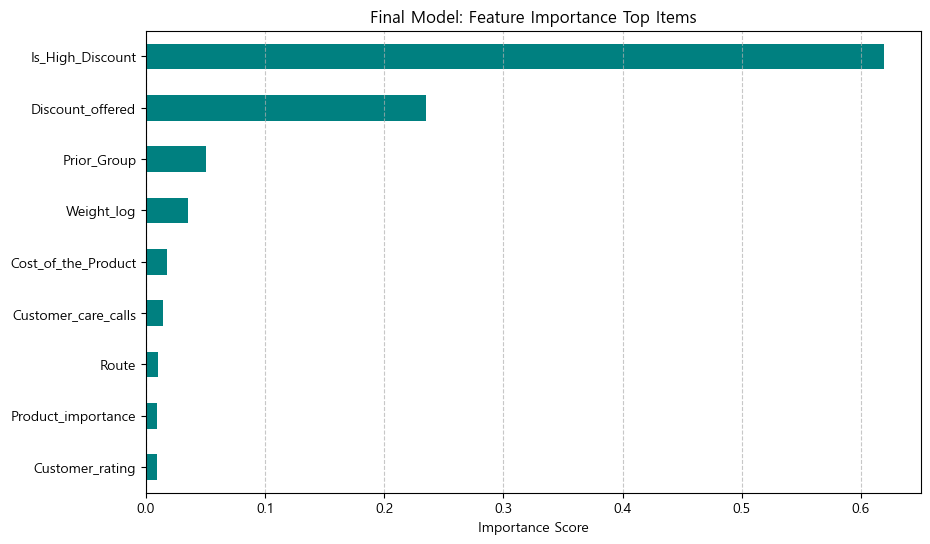

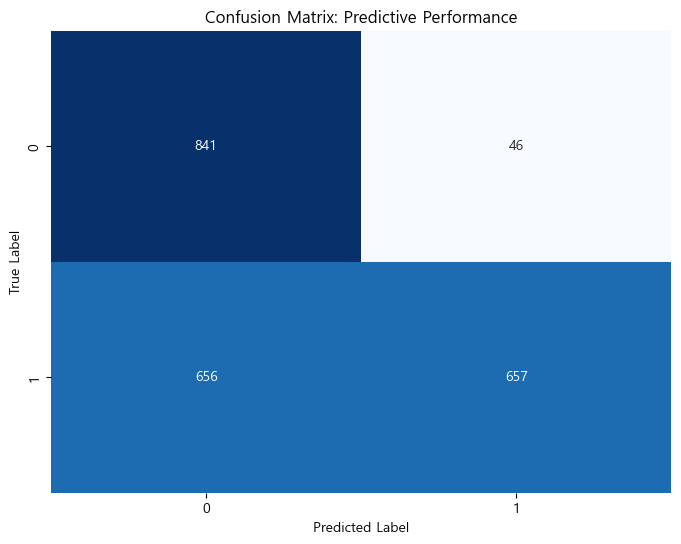

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. 데이터 로드
df = pd.read_csv('data/Train.csv')

# 2. [Feature Engineering] 모든 인사이트 집약
# (1) 할인율 전략: 10% 초과 여부 (지연의 핵심 트리거)
df['Is_High_Discount'] = (df['Discount_offered'] > 10).astype(int)

# (2) 무게 전략 (팀원): 로그 변환 + 3단계 레이블링
df['Weight_log'] = np.log1p(df['Weight_in_gms'])
df['Weight_Level'] = pd.cut(df['Weight_in_gms'], 
                            bins=[0, 2000, 4000, 10000], 
                            labels=[0, 1, 2]).astype(int)

# (3) 구매 횟수 전략 (팀원): 6회 이상 충성 고객 그룹화 (노이즈 제거)
df['Prior_Group'] = df['Prior_purchases'].apply(lambda x: x if x < 6 else 6)

# (4) 경로 전략 (최종): 창고(Warehouse) + 배송수단(Shipment) 조합
df['Route'] = df['Warehouse_block'].astype(str) + '_' + df['Mode_of_Shipment'].astype(str)

# 3. 인코딩 및 학습 준비
le = LabelEncoder()
# 범주형 변수들을 숫자로 변환
cat_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Route']
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# 사용할 특징 선별 (중요도가 낮았던 변수는 제외하거나 유지 가능)
features = [
    'Route', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 
    'Prior_Group', 'Product_importance', 'Is_High_Discount', 'Weight_log', 
    'Discount_offered' # 모델이 상세 수치도 참고할 수 있게 유지
]

X = df[features]
y = df['Reached.on.Time_Y.N']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. 최종 모델 학습 (과적합 방지를 위해 n_estimators=100으로 최적화)
final_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

final_model.fit(X_train, y_train)

# 5. 성능 평가 결과 출력
train_acc = accuracy_score(y_train, final_model.predict(X_train))
test_acc = accuracy_score(y_test, final_model.predict(X_test))

print(f"--- [최종 모델 성적] ---")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"격차: {abs(train_acc - test_acc):.4f}")
print("\n--- [상세 진단 보고서] ---")
print(classification_report(y_test, final_model.predict(X_test)))

# 6. [시각화 1] 변수 중요도 (Feature Importance)
plt.figure(figsize=(10, 6))
importances = pd.Series(final_model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', color='teal')
plt.title('Final Model: Feature Importance Top Items')
plt.xlabel('Importance Score')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 7. [시각화 2] 혼동 행렬 (Confusion Matrix)
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, final_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Predictive Performance')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

[LightGBM] [Info] Number of positive: 5250, number of negative: 3549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 8799, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596659 -> initscore=0.391562
[LightGBM] [Info] Start training from score 0.391562
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.659545   0.814031 0.556740  0.661239
      Random Forest  0.677273   0.954751 0.482102  0.640688
            XGBoost  0.680000   0.922330 0.506474  0.653884
           LightGBM  0.661364   0.842169 0.532369  0.652357


c:\Users\lamph\miniconda3\envs\DS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\lamph\AppData\Local\Temp\ipykernel_3220\3213263657.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=result_df.sort_values(by='Accuracy', ascending=False), palette='viridis')


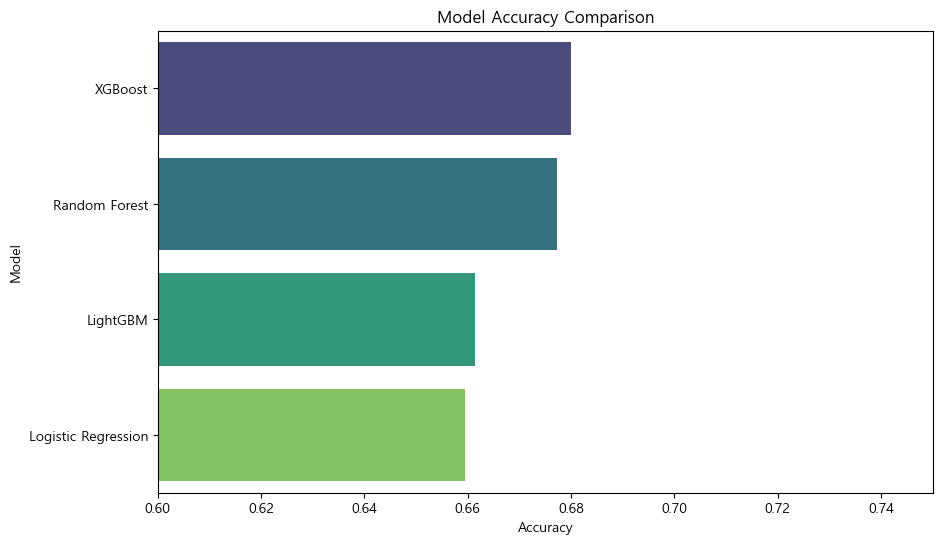

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. 데이터 로드 및 전처리 (이전과 동일)
df = pd.read_csv('data/Train.csv')
df['Is_High_Discount'] = (df['Discount_offered'] > 10).astype(int)
df['Weight_log'] = np.log1p(df['Weight_in_gms'])
df['Prior_Group'] = df['Prior_purchases'].apply(lambda x: x if x < 6 else 6)
df['Route'] = df['Warehouse_block'].astype(str) + '_' + df['Mode_of_Shipment'].astype(str)

le = LabelEncoder()
cat_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Route']
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

features = ['Route', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 
            'Prior_Group', 'Product_importance', 'Is_High_Discount', 'Weight_log', 'Discount_offered']
X = df[features]
y = df['Reached.on.Time_Y.N']

# 수치형 변수 스케일링 (로지스틱 회귀를 위해 필요)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 2. 모델 리스트 정의
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
}

# 3. 모델별 학습 및 평가
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    })

# 4. 결과 테이블 출력
result_df = pd.DataFrame(results)
print(result_df.to_string(index=False))

# 5. [시각화] 모델별 성능 비교
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=result_df.sort_values(by='Accuracy', ascending=False), palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlim(0.6, 0.75) # 차이를 명확히 보기 위한 범위 설정
plt.show()

--- [모델 성능 평가 보고서] ---
Accuracy : 0.6800
ROC-AUC  : 0.7530

[상세 분류 보고서]
              precision    recall  f1-score   support

           0       0.56      0.94      0.70       887
           1       0.92      0.51      0.65      1313

    accuracy                           0.68      2200
   macro avg       0.74      0.72      0.68      2200
weighted avg       0.78      0.68      0.67      2200



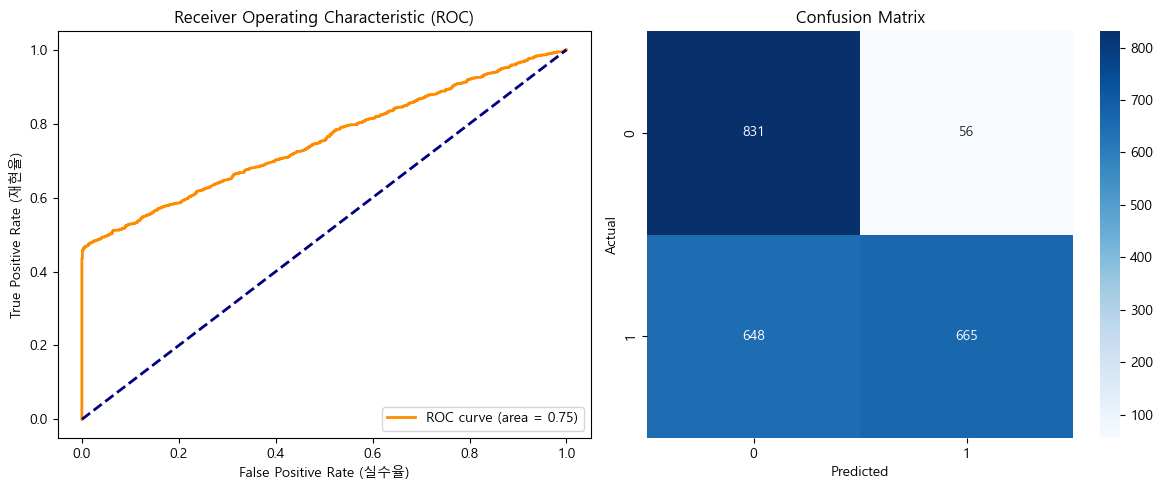

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# 1. 데이터 로드 및 전처리 (우리의 모든 전략 통합)
df = pd.read_csv('data/Train.csv')

# 피처 엔지니어링
df['Is_High_Discount'] = (df['Discount_offered'] > 10).astype(int)
df['Weight_log'] = np.log1p(df['Weight_in_gms'])
df['Prior_Group'] = df['Prior_purchases'].apply(lambda x: x if x < 6 else 6)
df['Route'] = df['Warehouse_block'].astype(str) + '_' + df['Mode_of_Shipment'].astype(str)

# 인코딩
le = LabelEncoder()
for col in ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Route']:
    df[col] = le.fit_transform(df[col].astype(str))

# 특성 선택
features = ['Route', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 
            'Prior_Group', 'Product_importance', 'Is_High_Discount', 'Weight_log', 'Discount_offered']
X = df[features]
y = df['Reached.on.Time_Y.N']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. 모델 학습 (XGBoost)
final_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    eval_metric='logloss'
)
final_model.fit(X_train, y_train)

# 3. 예측 및 확률 계산
y_pred = final_model.predict(X_test)
y_probs = final_model.predict_proba(X_test)[:, 1] # 지연(1)일 확률 추출

# 4. 성능 지표 출력
print(f"--- [모델 성능 평가 보고서] ---")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_probs):.4f}")
print("\n[상세 분류 보고서]")
print(classification_report(y_test, y_pred))

# 5. [시각화] ROC 커브
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_val = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(12, 5))

# 좌측: ROC 커브
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (실수율)')
plt.ylabel('True Positive Rate (재현율)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# 우측: 혼동 행렬
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

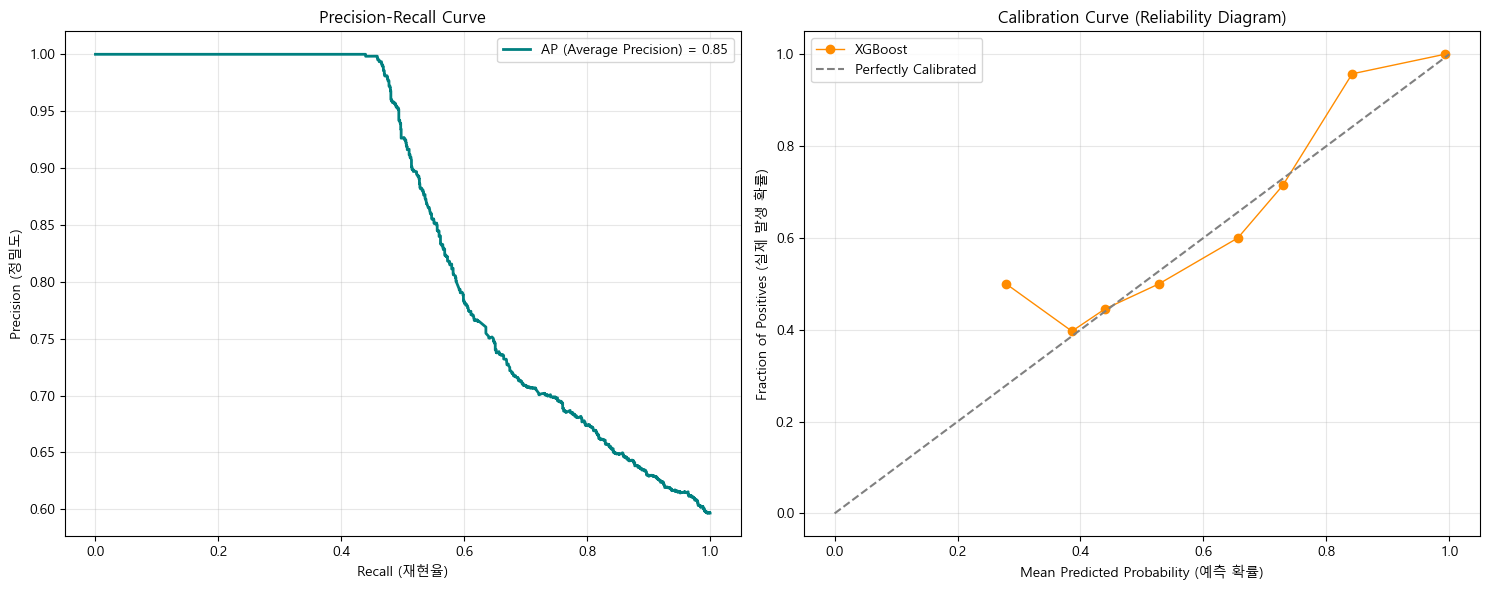

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve

# 1. 데이터 로드 및 전처리 (이전과 동일)
df = pd.read_csv('data/Train.csv')
df['Is_High_Discount'] = (df['Discount_offered'] > 10).astype(int)
df['Weight_log'] = np.log1p(df['Weight_in_gms'])
df['Route'] = df['Warehouse_block'].astype(str) + '_' + df['Mode_of_Shipment'].astype(str)

le = LabelEncoder()
for col in ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Route']:
    df[col] = le.fit_transform(df[col].astype(str))

X = df[['Route', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 
        'Prior_purchases', 'Product_importance', 'Is_High_Discount', 'Weight_log']]
y = df['Reached.on.Time_Y.N']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. 모델 학습
model = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42)
model.fit(X_train, y_train)
y_probs = model.predict_proba(X_test)[:, 1]

# 3. 시각화 (PR 커브 & Calibration 커브)
plt.figure(figsize=(15, 6))

# [좌측] PR 커브: 모델이 지연(1)을 얼마나 정확하게 잡아내는가?
plt.subplot(1, 2, 1)
precision, recall, _ = precision_recall_curve(y_test, y_probs)
ap_score = average_precision_score(y_test, y_probs)
plt.plot(recall, precision, color='teal', lw=2, label=f'AP (Average Precision) = {ap_score:.2f}')
plt.xlabel('Recall (재현율)')
plt.ylabel('Precision (정밀도)')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(alpha=0.3)

# [우측] Calibration 커브: 모델이 내뱉은 확률이 실제 확률과 일치하는가?
plt.subplot(1, 2, 2)
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='XGBoost', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability (예측 확률)')
plt.ylabel('Fraction of Positives (실제 발생 확률)')
plt.title('Calibration Curve (Reliability Diagram)')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

경고: Discount_offered 컬럼이 없어서 0으로 채웠습니다. 전처리 단계를 다시 확인해보세요!


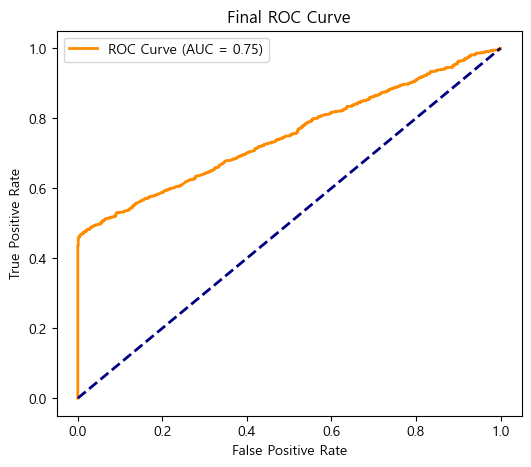

성공! ROC-AUC 점수: 0.7501


In [38]:
# 1. 모델이 실제로 학습할 때 사용한 컬럼 이름을 가져옵니다.
model_features = final_model.get_booster().feature_names

# 2. 현재 X_test에 없는 컬럼이 있다면, 0이나 기본값으로라도 채워줍니다.
# (XGBoost의 feature mismatch를 해결하는 가장 확실한 방법입니다)
for col in model_features:
    if col not in X_test.columns:
        # Prior_Group이 없고 Prior_purchases가 있다면 계산해서 넣어줌
        if col == 'Prior_Group' and 'Prior_purchases' in X_test.columns:
            X_test['Prior_Group'] = X_test['Prior_purchases'].apply(lambda x: x if x < 6 else 6)
        # Discount_offered가 사라졌다면 0으로라도 임시 생성 (에러 방지)
        else:
            X_test[col] = 0 
            print(f"경고: {col} 컬럼이 없어서 0으로 채웠습니다. 전처리 단계를 다시 확인해보세요!")

# 3. 모델이 배운 '순서' 그대로 다시 정렬
X_test_final = X_test[model_features]

# 4. ROC-AUC 계산 및 출력
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_probs = final_model.predict_proba(X_test_final)[:, 1]
auc_score = roc_auc_score(y_test, y_probs)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Final ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print(f"성공! ROC-AUC 점수: {auc_score:.4f}")

c:\Users\lamph\miniconda3\envs\DS\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:39:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 5250, number of negative: 3549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 8799, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596659 -> initscore=0.391562
[LightGBM] [Info] Start training from score 0.391562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

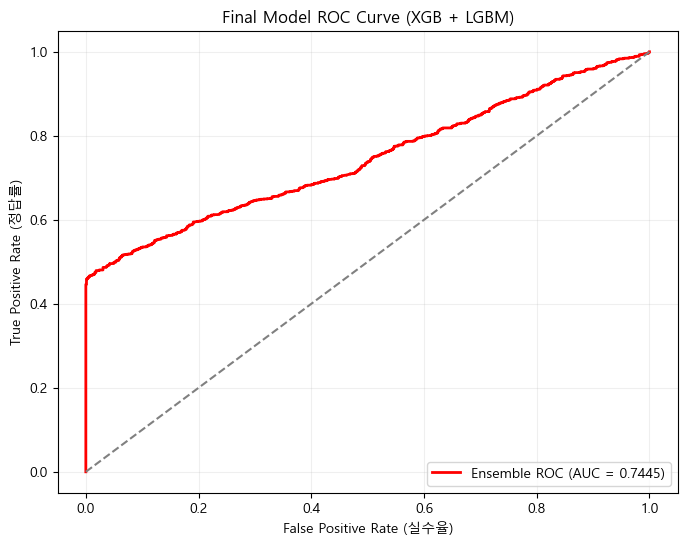

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

# 1. 데이터 로드
df = pd.read_csv('data/Train.csv')

# 2. 파생변수 생성 (Feature Engineering)
# 할인율 10% 초과 여부 (지연의 핵심 트리거)
df['Is_High_Discount'] = (df['Discount_offered'] > 10).astype(int)
# 무게 로그 변환 (치우친 데이터 완화)
df['Weight_log'] = np.log1p(df['Weight_in_gms'])
# 배송 경로 조합 (창고 x 배송수단)
df['Route'] = df['Warehouse_block'].astype(str) + '_' + df['Mode_of_Shipment'].astype(str)

# 3. 인코딩 (범주형 -> 수치형)
le = LabelEncoder()
categorical_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Route']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# 4. 학습 데이터 준비
# 중요도와 상관관계가 높은 변수들 위주로 구성
features = ['Route', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 
            'Prior_purchases', 'Product_importance', 'Is_High_Discount', 'Weight_log', 'Discount_offered']
X = df[features]
y = df['Reached.on.Time_Y.N']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5. 앙상블 모델 구축 (XGBoost + LightGBM)
xgb = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='logloss')
lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)

ensemble = VotingClassifier(
    estimators=[('xgb', xgb), ('lgbm', lgbm)],
    voting='soft' # 확률 기반 평균
)

# 6. 모델 학습 및 예측
ensemble.fit(X_train, y_train)
y_probs = ensemble.predict_proba(X_test)[:, 1]
y_pred = ensemble.predict(X_test)

# 7. 결과 출력 및 시각화
auc_score = roc_auc_score(y_test, y_probs)
acc_score = accuracy_score(y_test, y_pred)

print(f"=== 최종 모델 성능 ===")
print(f"Accuracy : {acc_score:.4f}")
print(f"ROC-AUC  : {auc_score:.4f}")

# ROC 커브 시각화
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'Ensemble ROC (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (실수율)')
plt.ylabel('True Positive Rate (정답률)')
plt.title('Final Model ROC Curve (XGB + LGBM)')
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

c:\Users\lamph\miniconda3\envs\DS\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:39:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 5250, number of negative: 3549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 8799, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596659 -> initscore=0.391562
[LightGBM] [Info] Start training from score 0.391562

=== 모델별 성능 순위 ===
                 Model   ROC-AUC
4             CatBoost  0.749531
1        Random Forest  0.737310
2              XGBoost  0.736044
3             LightGBM  0.730861
0  Logistic Regression  0.726172


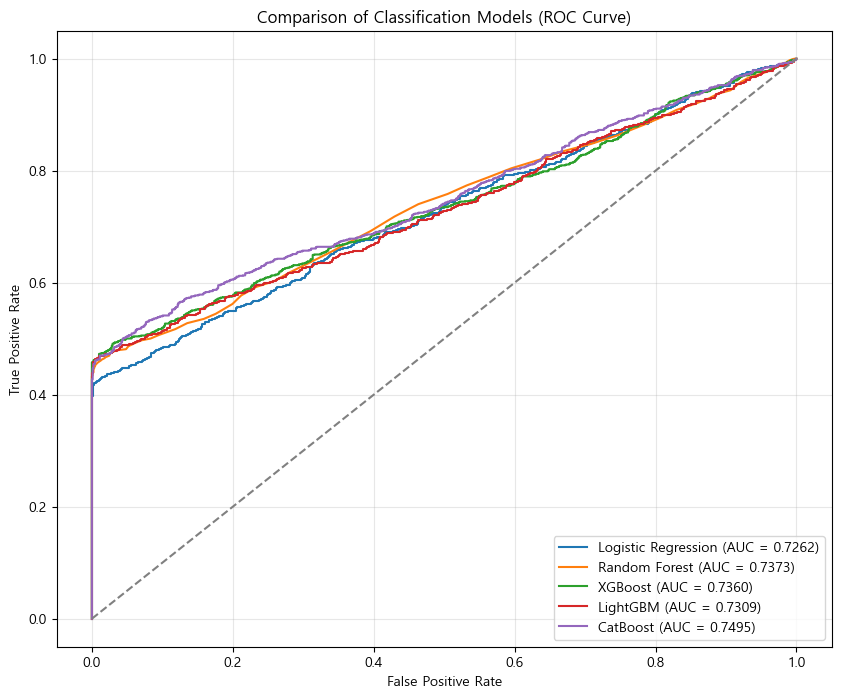

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve

# 사용할 모델들 임포트
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 1. 데이터 로드 및 전처리 (이전과 동일)
df = pd.read_csv('data/Train.csv')
df['Is_High_Discount'] = (df['Discount_offered'] > 10).astype(int)
df['Weight_log'] = np.log1p(df['Weight_in_gms'])

le = LabelEncoder()
for col in ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']:
    df[col] = le.fit_transform(df[col].astype(str))

features = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls', 'Customer_rating', 
            'Cost_of_the_Product', 'Prior_purchases', 'Product_importance', 
            'Is_High_Discount', 'Weight_log', 'Discount_offered']
X = df[features]
y = df['Reached.on.Time_Y.N']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. 비교할 모델 리스트 정의
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('XGBoost', XGBClassifier(n_estimators=100, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss')),
    ('LightGBM', LGBMClassifier(n_estimators=100, learning_rate=0.05)),
    ('CatBoost', CatBoostClassifier(iterations=100, learning_rate=0.05, verbose=0))
]

# 3. 모델별 학습 및 평가
results = []
plt.figure(figsize=(10, 8))

for name, model in models:
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측 확률값 추출
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # AUC 계산
    auc = roc_auc_score(y_test, y_probs)
    results.append((name, auc))
    
    # ROC 커브 시각화 데이터 준비
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

# 4. 결과 출력 및 시각화
results_df = pd.DataFrame(results, columns=['Model', 'ROC-AUC']).sort_values(by='ROC-AUC', ascending=False)
print("\n=== 모델별 성능 순위 ===")
print(results_df)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of Classification Models (ROC Curve)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

SMOTE 적용 전 학습 데이터 수: 8799
SMOTE 적용 후 학습 데이터 수: 10500
0:	test: 0.6984006	best: 0.6984006 (0)	total: 3.62ms	remaining: 1.8s
100:	test: 0.7457405	best: 0.7570535 (6)	total: 546ms	remaining: 2.16s
200:	test: 0.7399932	best: 0.7570535 (6)	total: 1.07s	remaining: 1.59s
300:	test: 0.7326698	best: 0.7570535 (6)	total: 1.58s	remaining: 1.04s
400:	test: 0.7302665	best: 0.7570535 (6)	total: 2.1s	remaining: 520ms
499:	test: 0.7299351	best: 0.7570535 (6)	total: 2.62s	remaining: 0us

bestTest = 0.7570535217
bestIteration = 6

Shrink model to first 7 iterations.


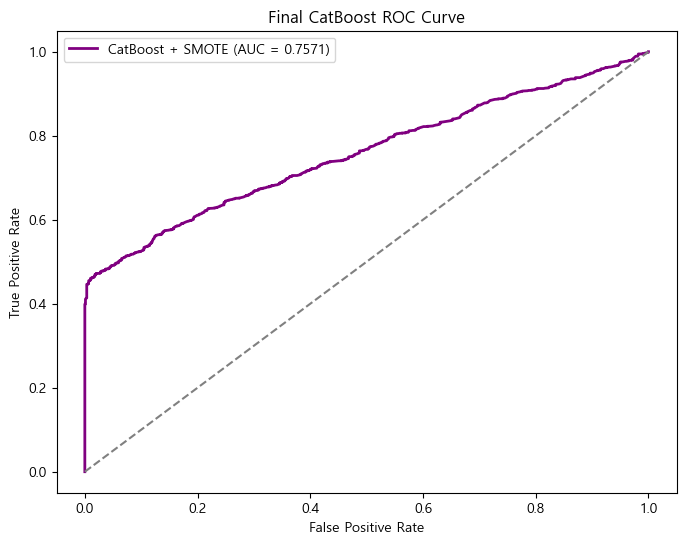

최종 CatBoost ROC-AUC 점수: 0.7571


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE # 데이터 불균형 해소 도구

# 1. 데이터 로드 및 전처리
df = pd.read_csv('data/Train.csv')
df['Is_High_Discount'] = (df['Discount_offered'] > 10).astype(int)
df['Weight_log'] = np.log1p(df['Weight_in_gms'])
df['Route'] = df['Warehouse_block'].astype(str) + '_' + df['Mode_of_Shipment'].astype(str)

le = LabelEncoder()
for col in ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Route']:
    df[col] = le.fit_transform(df[col].astype(str))

features = ['Route', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 
            'Prior_purchases', 'Product_importance', 'Is_High_Discount', 'Weight_log', 'Discount_offered']
X = df[features]
y = df['Reached.on.Time_Y.N']

# 2. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. SMOTE 적용 (데이터 불균형 해소)
# 적은 쪽 데이터를 가상으로 만들어내서 5:5 비율로 맞춥니다.
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"SMOTE 적용 전 학습 데이터 수: {len(X_train)}")
print(f"SMOTE 적용 후 학습 데이터 수: {len(X_train_res)}")

# 4. CatBoost 모델 학습
# CatBoost는 자체적으로 범주형 변수를 지정할 수 있지만, 여기서는 이미 인코딩된 데이터를 씁니다.
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=100 # 100회마다 학습 결과 출력
)

cat_model.fit(X_train_res, y_train_res, eval_set=(X_test, y_test))

# 5. 결과 확인 및 시각화
y_probs = cat_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_probs)

fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'CatBoost + SMOTE (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Final CatBoost ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print(f"최종 CatBoost ROC-AUC 점수: {auc_score:.4f}")

In [43]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# 1. 모델 예측 (이미 모델 학습이 완료된 상태여야 합니다)
y_pred = cat_model.predict(X_test)      # 0 또는 1로 예측
y_probs = cat_model.predict_proba(X_test)[:, 1] # 확률값으로 예측

# 2. 결과 출력
print("--- [모델 성능 평가 보고서] ---")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_probs):.4f}")
print("\n[상세 분류 보고서]")
print(classification_report(y_test, y_pred))

--- [모델 성능 평가 보고서] ---
Accuracy : 0.6736
ROC-AUC  : 0.7571

[상세 분류 보고서]
              precision    recall  f1-score   support

           0       0.55      0.99      0.71       887
           1       0.99      0.46      0.63      1313

    accuracy                           0.67      2200
   macro avg       0.77      0.72      0.67      2200
weighted avg       0.81      0.67      0.66      2200



.